# 1. Mount Google Drive & Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu8/"

Mounted at /content/drive


# 2. Install Library

In [ ]:
!pip install ekphrasis sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.5 MB/s eta 0:00:00


# 3. Import Library

In [ ]:
import re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

%matplotlib inline

# 4. Load Dataset

In [ ]:
df = pd.read_csv(BASE_PATH + "Dataset_Sentimen_Emosi.csv")
df = df.drop(columns=['Emosi'])   # kolom tidak dipakai
df.head()

,Tweet,Sentimen
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0
4,Covid belum nyampe prigen mbak hmm hoax,0.0


# 5. Text Preprocessor (Ekphrasis)

In [ ]:
text_processor = TextPreProcessor(
    normalize=['email','percent','money','phone','user','time','date','number'],
    annotate={"hashtag","allcaps","elongated","repeated","emphasis","censored"},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


# 6. Fungsi Preprocessing

In [ ]:
def clean_text(text):
    text = " ".join(text_processor.pre_process_doc(text))
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+|#\w+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

In [ ]:
df["step01"] = df["Tweet"].astype(str).apply(clean_text)
df = df[df["step01"].str.strip() != ""]
df.head()

,Tweet,Sentimen,step01
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax


# 7. Tokenisasi & Normalisasi Kata

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

df["tokens"] = df["step01"].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# 8. Stopword Removal

In [ ]:
from nltk.corpus import stopwords
nltk.download("stopwords")

stopword = stopwords.words('indonesian')
df["tokens"] = df["tokens"].apply(lambda x: [w for w in x if w not in stopword])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 9. Stemming (Sastrawi)

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

df["ProcessedText"] = df["tokens"].apply(lambda x: stemmer.stem(" ".join(x)))
df.head()

,Tweet,Sentimen,step01,tokens,ProcessedText
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, be...",emang lemes bgt ya mulut lu gue yg beli beli o...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari rumah ming...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah moga wabah covid number hilang r...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naik status tanggap darurat covi...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, nyampe, prigen, mbak, hmm, hoax]",covid nyampe prigen mbak hmm hoax


# 10. Simpan Hasil Preprocessing

In [ ]:
clean_path = BASE_PATH + "clean_dataset_part01.csv"
df.to_csv(clean_path, sep=";", index=False)
print("Saved to:", clean_path)

Saved to: /content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu8/clean_dataset_part01.csv


# MACHINE LEARNING — NAIVE BAYES

# 11. Load Dataset Clean

In [ ]:
dataset = pd.read_csv(clean_path, sep=";")

In [ ]:
dataset = dataset.dropna(subset=["Sentimen"])
dataset = dataset.reset_index(drop=True)

In [ ]:
X = dataset["ProcessedText"].astype(str)
y = dataset["Sentimen"]

# 12. Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 13. Pipeline TF-IDF + Naive Bayes

In [ ]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB())
])

params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'model__alpha': [0.1, 1, 10]
}

model_nb = GridSearchCV(pipeline_nb, params, cv=3, n_jobs=-1)
model_nb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

# 14. Evaluasi Model

In [ ]:
y_pred = model_nb.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))

Accuracy : 0.625
Recall   : 0.625
Precision: 0.6153122273091313
F1-score : 0.6004280335322535


# 15. Confusion Matrix

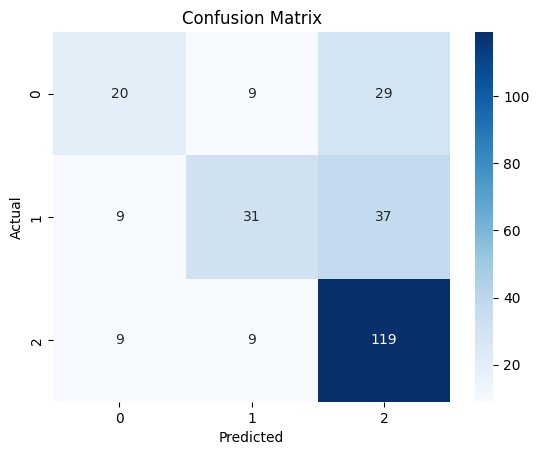

In [21]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 16. Simpan Model

In [22]:
import joblib

model_path = BASE_PATH + "naive_bayes_model.sav"
joblib.dump(model_nb.best_estimator_, model_path)
print("Model saved to:", model_path)

Model saved to: /content/drive/My Drive/Colab Notebooks/SistemTemuKembaliInformasi/Minggu8/naive_bayes_model.sav


# 17. Kesimpulan

### Nilai accuracy menunjukkan bahwa model mampu mengklasifikasikan sebagian besar data dengan benar, namun masih terdapat kesalahan yang cukup signifikan. Nilai recall yang sebanding dengan accuracy mengindikasikan bahwa model belum optimal dalam mengenali seluruh data pada tiap kelas sentimen. Nilai precision yang sedikit lebih rendah menunjukkan masih adanya prediksi sentimen yang kurang tepat. Sementara itu, F1-score yang paling rendah mencerminkan keseimbangan antara precision dan recall yang belum optimal akibat keterbatasan model dan karakteristik data tweet.